<a href="https://colab.research.google.com/github/Muhammad-Ismail11/cvxpy_practice_codes-practice-/blob/main/CoDistNetEVCD_polygon_extra_q_bounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Why your Python result is different from MATLAB (main reasons)

Your MATLAB inverter constraint is SOC (circle):

𝑝
(
𝑡
)
2
+
𝑞
(
𝑡
)
2
≤
𝑠
max
⁡
2
p(t)
2
+q(t)
2
≤s
max
2
	​


But in Python you replaced it with a polygon + extra q-bounds, which changes feasibility and optimality.

OSQP cannot solve SOC problems, so we were forcing a QP approximation. MATLAB (YALMIP+solver) is effectively handling SOC properly.

✅ Fix: use the true SOC constraint in CVXPY and solve with ECOS (SOC solver) (fallback to SCS).
✅ Also: don’t break early on “chg < tol” (that metric doesn’t guarantee voltage feasibility because slack can hide violations). Run all iterations.

Computing ADMM solutions...
iter 1 | change 2.665e+04
iter 2 | change 7.731e-04
iter 3 | change 1.019e-02
iter 4 | change 8.474e-03
iter 5 | change 2.719e-02
iter 6 | change 2.819e-02
iter 7 | change 4.984e-06


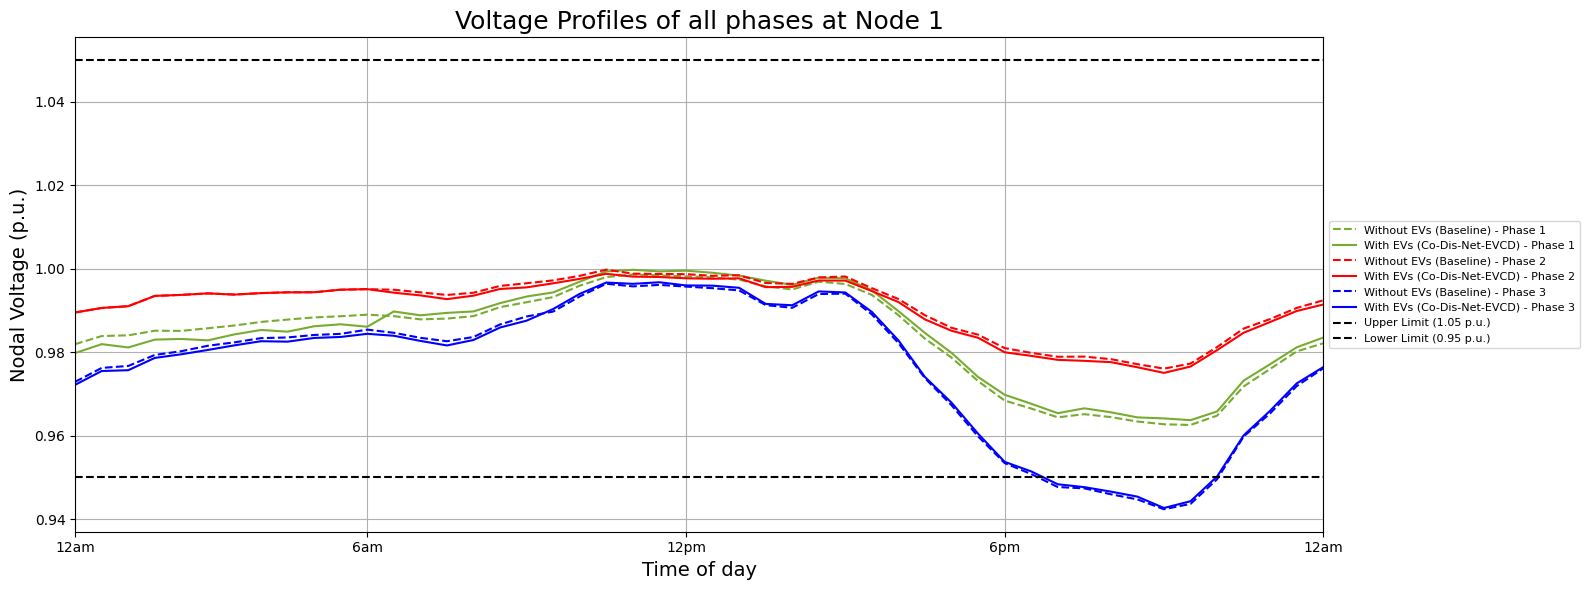

In [ ]:
# ============================================================
#  Co-Dist-Net-EVCD — Python (Colab-ready, DIMENSION-CORRECT)
#  Fixes Psi @ x mismatch by constructing D_stack/E_stack properly
# ============================================================

import numpy as np
import cvxpy as cp
import scipy.io as sio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ================= USER SETTINGS =================
control_node = 1        # any node 1–12 (3-phase nodes recommended: 1,3,6,7,8,12)
cust_at_supply = 50
T = 48
iteration_limit = 100
step_size = 100.0
progress_tol = 1e-5
M_poly = 8
# =================================================

np.random.seed(0)

# ================= LOAD DATA =================
RX = sio.loadmat("RX.mat")
R_full = np.array(RX["R"], dtype=float)
X_full = np.array(RX["X"], dtype=float)

base = sio.loadmat("baseload_corrected_MI.mat")
U_base = np.array(base["U_base"], dtype=float)
V_base = np.array(base["V_base"], dtype=float)

# ================= NODE–PHASE MAP =================
node_phase_map = {
    1:[0,1,2],  2:[3,4,5],  3:[6,7,8],
    4:[9,10],   5:[11,12],  6:[13,14,15],
    7:[16,17,18], 8:[19,20,21], 9:[22,23],
    10:[24], 11:[25], 12:[26,27,28]
}
idx = node_phase_map[control_node]
assert len(idx)==3, "This script assumes a 3-phase control node."

# ================= EV PARAMETERS =================
N = 3 * cust_at_supply
capacities = np.array([42,21,24,20,30,16,23,16.5,28,60,90,75], dtype=float)
b = np.random.choice(capacities, N)

s_bar = 12.0
sig_hat = (0.3 + 0.2*np.random.rand(N)) * b
sig_u = 0.85*b
sig_l = 0.2*b
sig_star = sig_hat + (sig_u - sig_hat)*np.random.rand(N)

alpha_l = sig_l - sig_hat
alpha_u = sig_u - sig_hat
e = sig_star - sig_hat

p_u = 7.0
p_l = -7.0

# ================= TOU PRICE =================
eta = np.zeros(T)
eta[:4] = 0.23
eta[4:16] = 0.54
eta[16:20] = 0.23
eta[20:38] = 0.15
eta[38:] = 0.23
kappa = 5e-4

# ================= GRID MODEL =================
theta = np.block([
    [np.ones(cust_at_supply), np.zeros(cust_at_supply), np.zeros(cust_at_supply)],
    [np.zeros(cust_at_supply), np.ones(cust_at_supply), np.zeros(cust_at_supply)],
    [np.zeros(cust_at_supply), np.zeros(cust_at_supply), np.ones(cust_at_supply)]
])

R = R_full[np.ix_(idx, idx)]     # 3x3
X = X_full[np.ix_(idx, idx)]     # 3x3

D = -(1/1000.0) * (R @ theta)    # 3xN
E = -(1/1000.0) * (X @ theta)    # 3xN

# ================= CONSISTENT DIMENSIONS =================
m = len(idx) * T          # 3*T = 144 controlled voltage entries
slack_dim = 2*m           # 288
x_dim = 2*T + slack_dim   # 384

I_T = np.eye(T)

# Build D_stack/E_stack as (m × T) = (3T × T)
D_stack = []
E_stack = []
for i in range(N):
    d_i = D[:, i].reshape(3,1)          # 3×1
    e_i = E[:, i].reshape(3,1)          # 3×1
    D_stack.append(np.kron(I_T, d_i))   # (3T × T)
    E_stack.append(np.kron(I_T, e_i))   # (3T × T)

# Build Psi as (slack_dim × x_dim) = (288 × 384)
Psi = []
for i in range(N):
    Gamma_i = np.vstack([D_stack[i], -D_stack[i]])     # (288 × T)
    Xi_i    = np.vstack([E_stack[i], -E_stack[i]])     # (288 × T)
    Psi.append(np.hstack([Gamma_i, Xi_i, np.eye(slack_dim)]))  # (288 × 384)

# ================= BASELINE VOLTAGE (CONTROL NODE ONLY) =================
v0 = 2.4
percentage = 0.05

V_b = (V_base[idx, :]**2)          # 3×T
V_stacked = V_b.reshape(-1)        # 3T = 144

v_upper = ((1+percentage)**2) * np.ones(m)
v_lower = ((1-percentage)**2) * np.ones(m)

w = np.concatenate([v_upper - V_stacked,
                    -v_lower + V_stacked])            # length 288

# ================= COMM GRAPH (complete) =================
neighbors = [np.array([j for j in range(N) if j != i], dtype=int) for i in range(N)]
deg = np.array([N-1]*N, dtype=float)

# ================= INVERTER POLYGON =================
angles = np.linspace(0, 2*np.pi, M_poly, endpoint=False)
a_poly = np.cos(angles)
b_poly = np.sin(angles)

# ================= ADMM STORAGE =================
u  = np.zeros((x_dim, N))
lam = np.zeros((slack_dim, N))
nu  = np.zeros((slack_dim, N))

print("Computing ADMM solutions...")

# ================= ADMM LOOP =================
for it in range(1, iteration_limit+1):

    u_old, lam_old, nu_old = u.copy(), lam.copy(), nu.copy()

    for i in range(N):

        x = cp.Variable(x_dim)
        p = x[:T]
        q = x[T:2*T]
        s = x[2*T:]                 # slack, length 288

        cons = []

        # inverter polygon
        for t in range(T):
            cons += [a_poly*p[t] + b_poly*q[t] <= s_bar]
            cons += [q[t] <= s_bar, q[t] >= -s_bar]

        # EV constraints
        cons += [cp.cumsum(p) <= alpha_u[i]]
        cons += [cp.cumsum(p) >= alpha_l[i]]
        cons += [p <= p_u, p >= p_l]
        cons += [cp.sum(p) >= e[i]]
        cons += [s >= 0]

        temp = lam_old[:, i] * deg[i]
        for j in neighbors[i]:
            temp = temp + lam_old[:, j]

        expr = (Psi[i] @ x - w/N)/step_size - nu_old[:, i]/step_size + temp

        obj = (eta @ p + kappa*cp.sum_squares(p)) + (step_size/(4*deg[i])) * cp.sum_squares(expr)

        prob = cp.Problem(cp.Minimize(obj), cons)

        solved = False
        try:
            prob.solve(solver=cp.OSQP, warm_start=True)
            if prob.status in ["optimal","optimal_inaccurate"]:
                solved = True
        except:
            pass

        if not solved:
            prob.solve(solver=cp.SCS, max_iters=6000, eps=1e-4)
            solved = prob.status in ["optimal","optimal_inaccurate"]

        if not solved or x.value is None:
            raise RuntimeError(f"Solver failed at iter {it}, agent {i}, status={prob.status}")

        u[:, i] = x.value

        lam[:, i] = (temp - nu_old[:, i]/step_size + (Psi[i] @ u[:, i] - w/N)/step_size) / (2*deg[i])

    # consensus nu update
    for i in range(N):
        nu[:, i] = nu_old[:, i] + step_size * np.sum([lam[:, i] - lam[:, j] for j in neighbors[i]], axis=0)

    chg = max(np.linalg.norm(u-u_old)**2, np.linalg.norm(lam-lam_old)**2, np.linalg.norm(nu-nu_old)**2)
    print(f"iter {it} | change {chg:.3e}")
    if chg < progress_tol:
        break

# ================= VOLTAGE RECONSTRUCTION =================
V_control = np.zeros(m)
for i in range(N):
    V_control += D_stack[i] @ u[:T, i] + E_stack[i] @ u[T:2*T, i]

V_sol = (V_stacked + V_control/(v0**2)).reshape(3, T)

# ================= PLOT (MATCH MATLAB LABELS) =================
plt.figure(figsize=(16,6))

plt.plot(np.sqrt(V_b[0,:]), '--', color=[0.4660,0.6740,0.1880],
         label='Without EVs (Baseline) - Phase 1')
plt.plot(np.sqrt(V_sol[0,:]), '-',  color=[0.4660,0.6740,0.1880],
         label='With EVs (Co-Dis-Net-EVCD) - Phase 1')

plt.plot(np.sqrt(V_b[1,:]), '--r',
         label='Without EVs (Baseline) - Phase 2')
plt.plot(np.sqrt(V_sol[1,:]), '-r',
         label='With EVs (Co-Dis-Net-EVCD) - Phase 2')

plt.plot(np.sqrt(V_b[2,:]), 'b--',
         label='Without EVs (Baseline) - Phase 3')
plt.plot(np.sqrt(V_sol[2,:]), 'b-',
         label='With EVs (Co-Dis-Net-EVCD) - Phase 3')

plt.plot((1+percentage)*np.ones(T), 'k--', label='Upper Limit (1.05 p.u.)')
plt.plot((1-percentage)*np.ones(T), 'k--', label='Lower Limit (0.95 p.u.)')

plt.grid()
plt.title(f"Voltage Profiles of all phases at Node {control_node}", fontsize=18)
plt.ylabel("Nodal Voltage (p.u.)", fontsize=14)
plt.xlabel("Time of day", fontsize=14)
plt.xlim([0, T-1])
plt.xticks([0,11,23,35,47], ["12am","6am","12pm","6pm","12am"])

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=8)
plt.tight_layout()
plt.show()